# Disaggregation calculation in openquake.hazardlib

In [1]:
%matplotlib inline

from openquake.hazardlib.source import AreaSource
from openquake.hazardlib.mfd import TruncatedGRMFD
from openquake.hazardlib.scalerel import WC1994
from openquake.hazardlib.geo import Point, NodalPlane, Polygon
from openquake.hazardlib.pmf import PMF
from openquake.hazardlib.tom import PoissonTOM
from openquake.hazardlib.calc.hazard_curve import calc_hazard_curves
from openquake.hazardlib.calc import disaggregation, mag_dist_pmf
from openquake.hazardlib.site import Site, SiteCollection
from openquake.hazardlib.imt import PGA
from openquake.hazardlib.gsim.campbell_bozorgnia_2008 import CampbellBozorgnia2008

import numpy
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

# Disaggregation for an area source

In [2]:
# define area source of circular shape of radius 200 km
src = AreaSource(
    source_id='1',
    name='area',
    tectonic_region_type='Active Shallow Crust',
    mfd=TruncatedGRMFD(min_mag=5., max_mag=6.5, bin_width=0.2, a_val=4.45, b_val=1.),
    rupture_mesh_spacing=2.,
    magnitude_scaling_relationship=WC1994(),
    rupture_aspect_ratio=1.,
    temporal_occurrence_model=PoissonTOM(50.),
    upper_seismogenic_depth=2.,
    lower_seismogenic_depth=12.,
    nodal_plane_distribution=PMF([(1, NodalPlane(strike=0., dip=90, rake=0.))]),
    hypocenter_distribution=PMF([(1, 7.)]),
    polygon=Point(0., 0.).to_polygon(200.),
    area_discretization=10.
)

## Hazard curve calculation

In [3]:
# first compute hazard curve
imls = [0.005, 0.007, 0.0098, 0.0137, 0.0192, 0.0269, 0.0376, 0.0527, 0.0738, 0.103, 0.145,
        0.203, 0.284, 0.397, 0.556, 0.778, 1.09, 1.52, 2.13]
site = Site(location=Point(0., 0.), vs30=760., vs30measured=True, z1pt0=40., z2pt5=1.)

curves = calc_hazard_curves(
    groups=[src],
    ss_filter=SiteCollection([site]),
    imtls={'PGA': imls},
    gsim_by_trt={'Active Shallow Crust': CampbellBozorgnia2008()},
    truncation_level=None
)

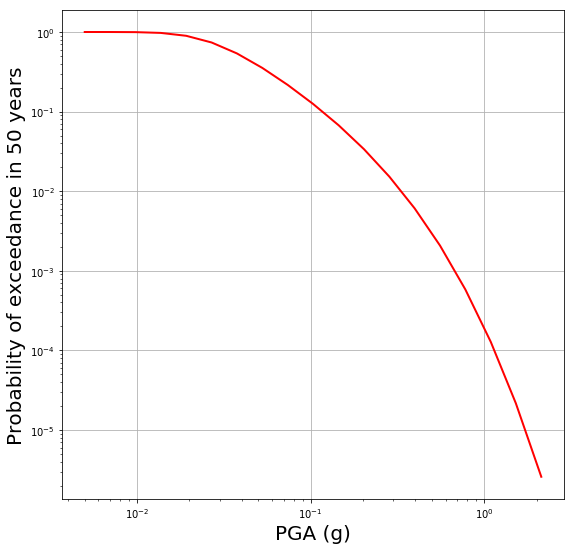

In [4]:
fig = pyplot.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
ax.plot(imls, curves['PGA'][0], '-r', linewidth=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
txt = ax.set_xlabel('PGA (g)', fontsize=20)
txt = ax.set_ylabel('Probability of exceedance in 50 years', fontsize=20)

## Disaggregation for poe = 0.1

In [5]:
# disaggregate ground motion value corresponding to 0.1 poe
poes = curves['PGA'][0]
iml = numpy.interp([0.1], poes[::-1], imls[::-1])

(mags, dists, lons, lats, eps, trts), diss_matrix = disaggregation(
    sources=[src],
    site=site,
    imt=PGA(),
    iml=iml,
    gsims={'Active Shallow Crust': CampbellBozorgnia2008()},
    truncation_level=3,
    n_epsilons=3,
    mag_bin_width=0.5,
    dist_bin_width=20.,
    coord_bin_width=0.2
)

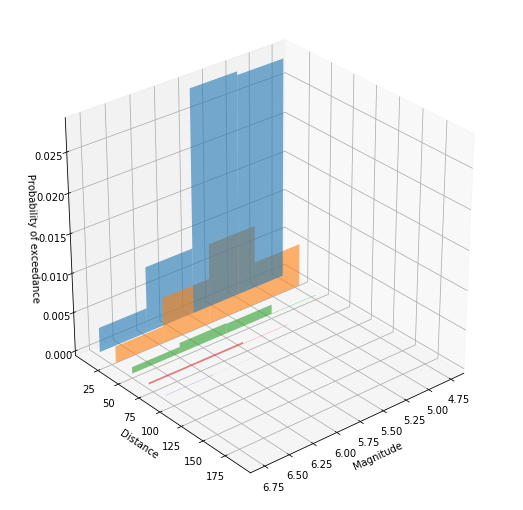

In [6]:
# compute magnitude distance disaggregation
mag_dist = mag_dist_pmf(diss_matrix)
mag_dist = mag_dist.T

fig = pyplot.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

y_ticks = (dists[: -1] + dists[1:]) / 2
for i, row in enumerate(mag_dist):
    ax.bar(mags[:-1], row, y_ticks[i], zdir='y', alpha=0.6, width=0.5)

ax.set_xlabel('Magnitude')
ax.set_ylabel('Distance')
ax.set_zlabel('Probability of exceedance')
ax.view_init(azim=50.)

## Disaggregation for poe = 0.001

In [7]:
iml = numpy.interp([0.001], poes[::-1], imls[::-1])

(mags, dists, lons, lats, eps, trts), diss_matrix = disaggregation(
    sources=[src],
    site=site,
    imt=PGA(),
    iml=iml,
    gsims={'Active Shallow Crust': CampbellBozorgnia2008()},
    truncation_level=3,
    n_epsilons=3,
    mag_bin_width=0.5,
    dist_bin_width=20.,
    coord_bin_width=0.2
)

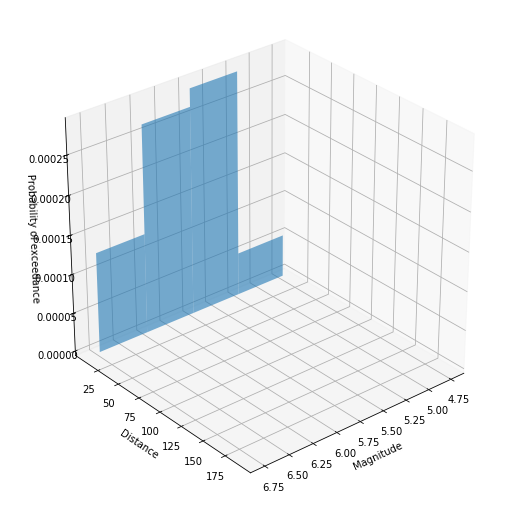

In [8]:
# compute magnitude distance disaggregation
mag_dist = mag_dist_pmf(diss_matrix)
mag_dist = mag_dist.T

fig = pyplot.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

y_ticks = (dists[: -1] + dists[1:]) / 2
for i, row in enumerate(mag_dist):
    ax.bar(mags[:-1], row, y_ticks[i], zdir='y', alpha=0.6, width=0.5)

ax.set_xlabel('Magnitude')
ax.set_ylabel('Distance')
ax.set_zlabel('Probability of exceedance')
ax.view_init(azim=50.)